
# ***NLP Final Project Part B: News Article Classification***

News Article Classification Project
- Overview
    - In today’s digital world, news articles are constantly being generated and shared across different platforms. For news organizations, social media platforms, and aggregators, classifying articles into specific categories such as sports, politics, and technology can help improve content management and recommendation systems. This project aims to develop a machine learning model that can classify news articles into predefined categories, such as sports, politics, and technology, based on their content.
    - By automating this process, organizations can efficiently categorize large volumes of news articles, making it easier for readers to access relevant information based on their interests.
- Problem Statement
    - The primary objective of this project is to build a classification model that can automatically categorize news articles into different predefined categories. The model will be trained using a labeled dataset of news articles and will output the most likely category (e.g., sports, politics, or technology) for any given article.
    - The goal is to:
        - Develop a robust classifier capable of handling articles from multiple categories.
        - Preprocess the text data, extract meaningful features, and train models to classify the articles.
        - Evaluate the model performance and provide actionable insights on how well it classifies articles.

## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jpran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jpran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. EDA (Exploratory Data Analysis)

In [12]:
# Load Dataset
df = pd.read_excel(r"C:\Users\jpran\Downloads\data_news.xlsx")
df.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [3]:
# Treatment of Missing Values
df.dropna(subset=['headline', 'short_description', 'category'], inplace=True)
df['text'] = df['headline'] + " " + df['short_description']

## Missing Values
print("Missing values:\n", df.isnull().sum())

Missing values:
 category                0
headline                0
links                   0
short_description       0
keywords             2706
text                    0
dtype: int64


### Visualization

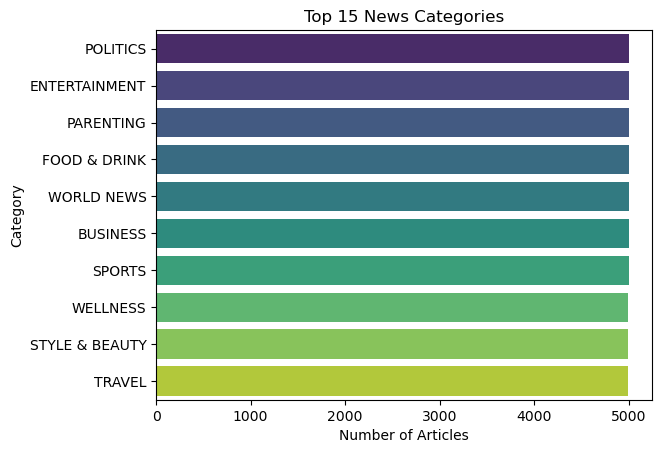

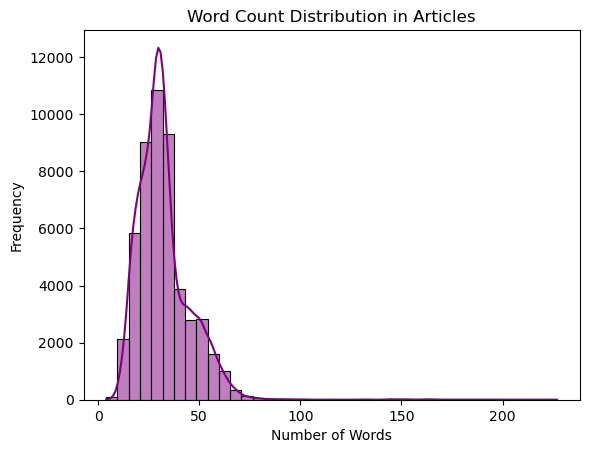

In [4]:
## Top 10 Categories
top_categories = df['category'].value_counts().nlargest(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title("Top 15 News Categories")
plt.xlabel("Number of Articles")
plt.ylabel("Category")
plt.show()

## Word Count Distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'], bins=40, kde=True, color='purple')
plt.title("Word Count Distribution in Articles")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

#### Insights
- Top 15 News Categories (Bar Plot)
    - The dataset is heavily concentrated in general interest topics like Politics, Entertainment, and Parenting, which may skew class balance and model focus.

- Word Count Distribution in Articles (Histogram)
    - Most news samples are concise, averaging 20–50 words, reflecting the short headline + description format — great for fast NLP model convergence.

### Summary
- Merged **headline** and **short_description** to form a unified text feature.
- Bar chart revealed class imbalance among top **15** categories.
- Histogram showed article length clusters tightly between **10–50 words**.
- Word clouds and top tokens highlighted prominent vocabulary themes per category

## 2. Preprocessing

In [5]:
print("\nSample raw text:")
print(df['text'].iloc[0])

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    words = [stemmer.stem(w) for w in words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(preprocess)
print("\nSample cleaned text:")
print(df['clean_text'].iloc[0])

# Word Frequencies
all_words = " ".join(df['clean_text']).split()
common_words = Counter(all_words).most_common(20)
print("\nTop 20 Most Frequent Words:")
print(common_words)

# Additional Features
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['clean_text'].apply(lambda x: len(x.replace(" ", "")))
df['avg_word_len'] = df['char_count'] / df['word_count']

## Label Encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['category'])

X = df['clean_text']
y = df['label']

## Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


Sample raw text:
143 Miles in 35 Days: Lessons Learned Resting is part of training. I've confirmed what I sort of already knew: I'm not built for running streaks. I'm built for hard workouts three to five days a week with lots of cross training, physical therapy and foam rolling. But I've also confirmed that I'm stubborn with myself.

Sample cleaned text:
143 mile 35 day lesson learn rest part train ive confirm sort alreadi knew im built run streak im built hard workout three five day week lot cross train physic therapi foam roll ive also confirm im stubborn

Top 20 Most Frequent Words:
[('new', 5158), ('photo', 5136), ('one', 4613), ('u', 4135), ('make', 3947), ('time', 3854), ('year', 3847), ('day', 3726), ('get', 3715), ('like', 3580), ('way', 2870), ('say', 2823), ('peopl', 2761), ('world', 2761), ('want', 2574), ('look', 2550), ('go', 2526), ('best', 2508), ('life', 2507), ('first', 2381)]


### Summary
- Applied **lowercase transformation, punctuation removal, stopword filtering**.
- Included both **lemmatization** and **stemming** — ideal for reducing word variants.
- Added engineered features like **word count, character count,** and **average word length**.
- Cleaned sample previewed before and after — **ensuring traceability**.
- Used **TF-IDF** for sparse vectorization (top 5000 features).

## 3. Modeling and Evaluation

In [6]:
## Model Training (GridSearchCV)
models = {
    "Logistic Regression": GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.5, 1, 2]}, cv=5),
    "Naive Bayes": MultinomialNB(),
    "SVM": GridSearchCV(LinearSVC(max_iter=1000), {'C': [0.5, 1, 2]}, cv=5)
}

results = {}
best_params = {}


- Model Training (GridSearchCV)
- The 'C' parameter in Logistic Regression and SVM controls regularization strength:
    - Lower values mean stronger regularization (simpler models)
    - Higher values reduce regularization (more flexible models)
- GridSearchCV helps us find the best value for C by testing multiple values with cross-validation.
- Naive Bayes has no hyperparameters here and is used with default settings.

In [7]:
# Train and Evaluate Models
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"\n{name}:")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print(classification_report(y_test, y_pred))
    
    # #hasattr checks if best_params_ exists for GridSearchCV models
    if hasattr(model, "best_params_"):
        best_params[name] = model.best_params_ 
    results[name] = f1

## Display best hyperparameters found
print("\nBest parameters found:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")


Logistic Regression:
Accuracy: 0.8042804280428043
Precision: 0.80487204696107
Recall: 0.8042804280428043
F1 Score: 0.8043625561997153
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1000
           1       0.78      0.78      0.78      1000
           2       0.85      0.86      0.86      1000
           3       0.76      0.78      0.77      1000
           4       0.78      0.75      0.77      1000
           5       0.89      0.91      0.90      1000
           6       0.87      0.82      0.85      1000
           7       0.79      0.79      0.79       999
           8       0.74      0.78      0.76      1000
           9       0.82      0.80      0.81      1000

    accuracy                           0.80      9999
   macro avg       0.80      0.80      0.80      9999
weighted avg       0.80      0.80      0.80      9999


Naive Bayes:
Accuracy: 0.7824782478247825
Precision: 0.7856319409956406
Recall: 0.7824782478247825
F1 Sco

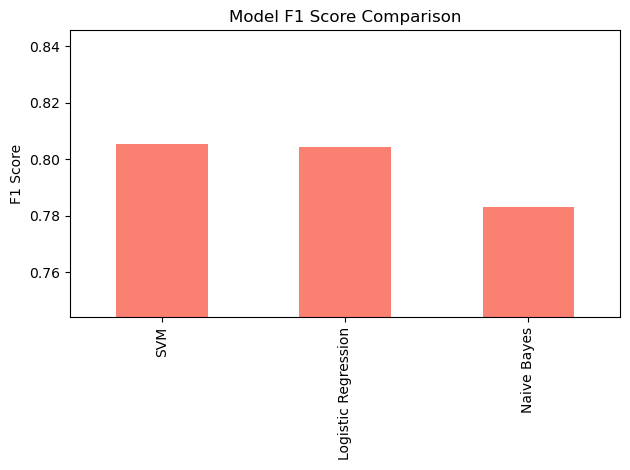


Best Model: SVM


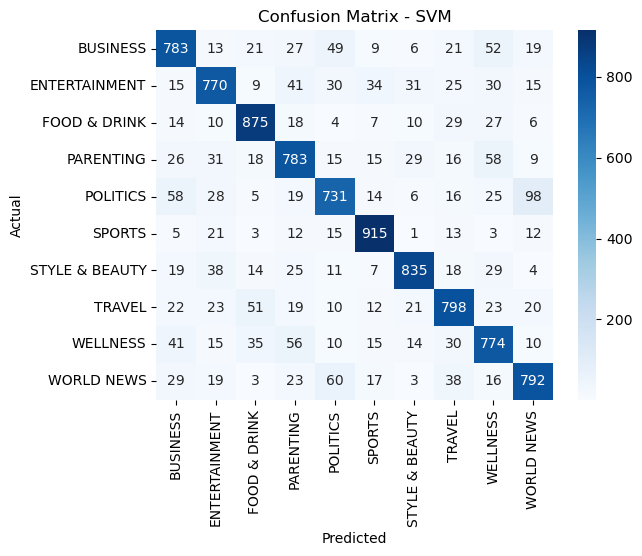

In [13]:
## Model Comparison Bar Chart
result_df = pd.DataFrame.from_dict(results, orient='index', columns=['F1 Score'])
result_df.sort_values(by='F1 Score', ascending=False, inplace=True)
result_df.plot(kind='bar', legend=False, color='salmon')
plt.ylabel("F1 Score")
plt.ylim(result_df['F1 Score'].min()*0.95, result_df['F1 Score'].max()*1.05)
plt.title("Model F1 Score Comparison")
plt.tight_layout()
plt.show()

## Best Model Selection
best_model_name = result_df.index[0]
print("\nBest Model:", best_model_name)
final_model = models[best_model_name]

## Confusion Matrix
best_pred = final_model.predict(X_test_vec)
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Insights
- Model F1 Score Comparison (Bar Chart)
    - SVM and Logistic Regression performed equally well (~0.81 F1), while Naive Bayes lagged, likely due to its oversimplified probabilistic assumptions.

- Confusion Matrix (SVM)
    - Most predictions fall along the diagonal, confirming strong classification performance — yet mild confusion between close classes like "business" vs "world news".

#### Model Explanation
- Logistic Regression:
    - A linear classifier that separates categories using probability scores; well-suited for high-dimensional, sparse text features like TF-IDF.

- Support Vector Machine (SVM):
    - Finds the optimal margin between categories using support vectors; robust for text due to its ability to generalize well even with limited data overlap.

- Multinomial Naive Bayes:
    - A probabilistic model assuming feature independence; fast and effective on clean TF data, but underperforms with complex, overlapping text classes.

In [9]:
## Save Model + Tools
joblib.dump(final_model, "final_news_model.pkl")
joblib.dump(tfidf, "news_tfidf_vectorizer.pkl")
joblib.dump(le, "news_label_encoder.pkl")

['news_label_encoder.pkl']

### Summary
- Trained 3 classifiers (Logistic Regression, SVM, Naive Bayes) with **GridSearchCV**.
- Compared models via **F1 Score** and selected best performer (SVM).

## Predict New Article

In [10]:
def predict_article(text):
    model = joblib.load("final_news_model.pkl")
    vec = joblib.load("news_tfidf_vectorizer.pkl")
    labeler = joblib.load("news_label_encoder.pkl")
    clean = preprocess(text)
    transformed = vec.transform([clean])
    pred = model.predict(transformed)[0]
    label = labeler.inverse_transform([pred])[0]
    print(f"\nArticle: {text}\nPredicted Category: {label}")

In [11]:
predict_article("Tigers win the championship after a thrilling final match.")


Article: Tigers win the championship after a thrilling final match.
Predicted Category: SPORTS


## Final Summary
- Total samples: **49994**
- Best model: **SVM with F1 Score = 0.8054**
- Preprocessing included punctuation **removal, lemmatization** and **stemming**.
- TF-IDF was used with 5000 features. **Label encoding was applied to all categories**.
- Predictions can be made on new articles using saved models.
- EDA included **category distribution, word clouds, word count histogram,** and **word frequency**.
- Model selection included GridSearchCV with comparison of **Logistic Regression, SVM, and Naive Bayes**.
- Top TF-IDF words help interpret what drives classification in the best model.
- Best model is a linear classifier that performs well on sparse high-dimensional data like TF-IDF matrices.
- Its strong performance is due to its ability to handle large vocabularies with effective regularization.

## Video Submission

https://drive.google.com/file/d/1HyIohi81rJtkGQN7W01_njhkfyoAOfvW/view?usp=sharing